<a href="https://colab.research.google.com/github/David-Svoboda/python_test/blob/master/lab1-binary-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab1: Binary image classifier

## 1. Setup
Install fastbook and setup Google drive connection.

In [2]:
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 12.1 MB/s 
     |████████████████████████████████| 189 kB 48.6 MB/s 
     |████████████████████████████████| 1.2 MB 44.9 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 275 kB/s 


Import necessary libraries

In [3]:
import fastai
print("Fastai version:", fastai.__version__)

import fastbook
print("Fastbook version:", fastbook.__version__)
fastbook.setup_book()

import torch
print("PyTorch version:", torch.__version__)

from fastbook import * # this will import search_images_bing()
from fastai.vision.widgets import *


Fastai version: 2.5.3
Fastbook version: 0.0.18
Mounted at /content/gdrive
PyTorch version: 1.10.0+cu111


## 2. Download images 
Use Azure image search or DuckDuckGo to download 150 images of each class. Save images to Google drive.

In [4]:
# your API key here
# get it in your https://portal.azure.com/
# key = YOUR-API-KEY
key = 'a81ebc8fe9fc499db577362b0ec0f5f0'

### 2.1 Try it out
Similar to the lecture notebook, try out your query and plot a few of the resulting images to verify that your search returns sensible images.

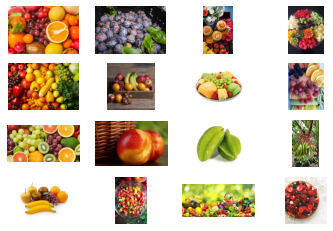

Path('/content/gdrive/MyDrive/Colab Notebooks/images/fruit.jpg')

In [5]:
#fastbook's v7 version
results = search_images_bing(key, 'fruit')

#Note: could use contentUrl for full size images
ims = results.attrgot('thumbnailUrl')
len(ims)

import matplotlib.pyplot as plt

f, axes = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        image_data = requests.get(ims[i+4*j])
        image_data.raise_for_status()
        image = Image.open(BytesIO(image_data.content))        
        axes[i][j].imshow(image)
        axes[i][j].axis("off")
plt.show()

export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/')
export_path.ls()

dest = export_path/'images/fruit.jpg'
download_url(ims[0], dest)

### 2.2 Get images for the two classes
Download 150 images of each class. Save images to Google drive.  
Remove any corrupt images using `verify_images()`.

In [6]:
fruit_types = 'apple','orange'
path = export_path/'fruit'
if not path.exists():
    path.mkdir()
    for o in fruit_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} fruit')
        download_images(dest, urls=results.attrgot('contentUrl'))


fns = get_image_files(path)
fns
failed = verify_images(fns)
failed.map(Path.unlink);

## 3. Setup image loaders
Setup image loaders, use 20% of images for validation, and show one batch for each training and validation dataset.

row1=training set, row2=validation set


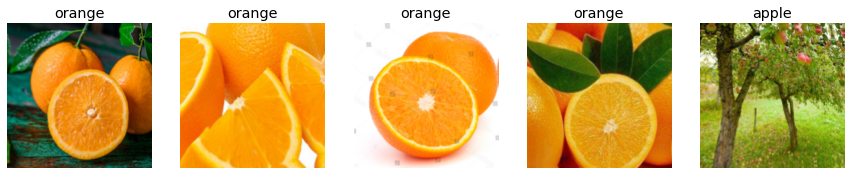

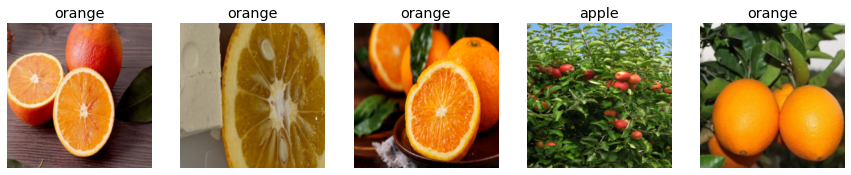

In [8]:
fruit = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #image->discrete category
    get_items=get_image_files, # path->images
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #how to train-valid split
    get_y=parent_label, # get the label from the directory name
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # random crop at each iteration, resize to 224x224
    batch_tfms=aug_transforms()) #a set of transformations like  rotation, flipping, perspective warping, brightness changes and contrast changes

dls = fruit.dataloaders(path)

dls.train.show_batch(max_n=5, nrows=1)
dls.valid.show_batch(max_n=5, nrows=1)
print('row1=training set, row2=validation set')

**Question 1:** How many images of each class are in trainging and validation sets?

*150X0.2=30 thus there are 30 images of each class are used for validation and 150-30=120, 120 images are used for the training sets*

## 4. Setup cnn learner
Setup a cnn learner with the dataloaders, `resnet18` architecture and `error_rate` as metric.

In [9]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 5. Train binary classifier
Fine tune for 10 epochs and show results.

In [10]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.190307,0.258251,0.086207,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.428542,0.225907,0.068965,00:14
1,0.341239,0.188966,0.068965,00:14
2,0.277330,0.175569,0.051724,00:14
3,0.214026,0.126863,0.051724,00:15
4,0.174229,0.112188,0.034483,00:14
5,0.154691,0.114937,0.034483,00:14
6,0.135632,0.118361,0.034483,00:14
7,0.117873,0.119903,0.051724,00:13
8,0.105555,0.123497,0.051724,00:13
9,0.097126,0.126258,0.051724,00:13


**Question 2:** Is the model overfitting? Why, why not?

*yes it is overfitting because the training loss gets lower and on the 0 epoch it is underfitting and on the 9th it is overfitting.*

## 6. Analyze results

Plot confusion matrix.

Plot top 5 losses.


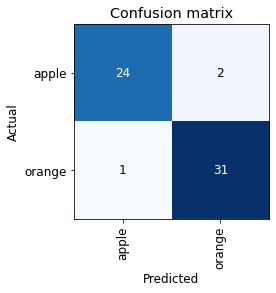

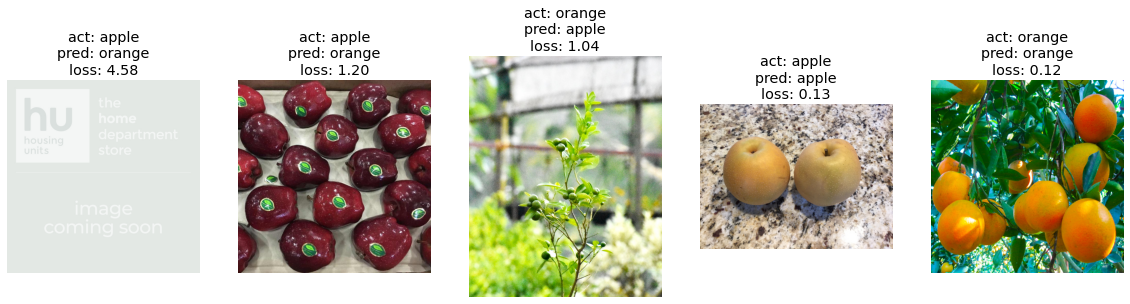

In [11]:
cat = ClassificationInterpretation.from_learner(learn)
cat.plot_confusion_matrix()

# For top losses
k=5
losses, idxs = cat.top_losses(k)
predicteds = cat.preds[idxs].argmax(axis=1)
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(20, 10))

for ax, id, loss, pred in zip(axs, idxs, losses, predicteds):
    img, actual = dls.valid_ds[id]
    img.show(ctx=ax)
    ax.set_title(f'act: {dls.vocab[actual.item()]}\npred: {dls.vocab[pred]}\nloss: {loss:.2f}')

**Question 3:** How many false positive, false negative errors?

*Assuming that apples are positive and oranges are negative there was 1 false positive and 2 false negatives*

## 7. Summary and Conclusion

Summarize:
- Type of classifier trained.
- Number of images of each class in the training validation sets
- Error rate achieved

*The tye of classyfier trained was a Binary Image Classyfier.

There were 150 images in each class of which 120 were Training set and 30 were validation set. 

learn.fine_tune(10)
The Error Rate achieved was 0.086207 
*

Conclusion:
- Are there any problems with data/labeling?

There was a probelm in my data when I tried to view the image in Drive as they were unrecognized initially so I had to remove those images. One image did not pass through my veriify image function, as seen by the blank image in my top 5 losses.  Also one image was a shrub (likely a young tree) and was thus very difficult to identify.
- Are you satisfied with model performance? Why, why not?

Yes the model performed very well making only 3 mistakes 2 of which were errors in data, it did well classifying what fruit was an apple or orange despite the similarity in shape and color.

*YOUR ANSWER HERE*


## 8. Reflection
Include a sentence or two about 
- what you liked or disliked, 
- found interesting, confusing, challangeing, motivating 

while working on this assignment.

*I loved how we used API keys to extract thedata from Bing and then applied machine learning.*